# Univariate regression to predict the wind speed field

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random

from utils.metrics import MetricsLogger
from utils.data_loaders import get_wake_dataloaders
import utils.utils as uutils
import utils.data_utils as data_utils
import utils.plotting as plotting
from utils.evaluation import test_pytorch_model

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [2]:
HIDDEN_LAYERS_UNITS = [50, 250]
ACTIVATION_FUNCTION = nn.Sigmoid()

class UnivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(UnivariateNN, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), ACTIVATION_FUNCTION]
        layers.append(nn.Linear(layer_units[-1], output_space)) # last layer not activated
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [7]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
MODEL_NAME = f"univariate_NN_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = True
COORDS_AS_INPUT = True # univariate setting
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

# hyperparameters
# in univariate, the batch size is a multiplier for number of cells
# (i.e. the batch_size should be dividible by the number of cells)
BATCH_MULTIPLIER = 1
EPOCHS = 160
LR = 0.001

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER}: act. func. {ACTIVATION_FUNCTION.__class__.__name__} " +\
    f"(not last layer), batch multiplier {BATCH_MULTIPLIER}, {EPOCHS} epochs, lr={LR})"
print(f"Model description: {MODEL_DESCRIPTION}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

DEVICE=device(type='cpu')
MODEL_DESCRIPTION='univariate_NN_layers50-250_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. Sigmoid (not last layer), batch multiplier 1, 160 epochs, lr=0.001)'


In [4]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          train_perc=0.6,
                                                          test_perc=0.2,
                                                          validation_perc=0.2,
                                                          batch_multiplier=BATCH_MULTIPLIER)
len(train_dataloader), len(test_dataloader)

5160

In [5]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.inputs.shape[1]
output_space = train_dataloader.dataset.outputs.shape[1]
print(f"{input_space=}\t{output_space=}")

torch.Size([7168, 4]) torch.Size([7168, 1])
input_space=4	output_space=1


In [6]:
model = UnivariateNN(input_space, output_space).to(DEVICE)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)
loss_function = torch.nn.MSELoss()

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    model.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model(x)
        tloss = loss_function(prediction, y)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_tloss += tloss.item() * x.size(0)
        #TODO accuracy or other metric computation????

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        model.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(x)
            vloss = loss_function(prediction, y)

            epoch_vloss += vloss.item() * x.size(0)

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), BEST_MODEL_PATH)


metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

Logging univariate_NN_layers50-250
Epoch 0 ->	Training loss=0.0008828650051687281	Validation loss=0.0008183889880477415	
Epoch 1 ->	Training loss=0.0006898856163769419	Validation loss=0.0006705826451146751	
Epoch 2 ->	Training loss=0.0006486137150204741	Validation loss=0.0006393478553861293	
Epoch 3 ->	Training loss=0.0005969381176624285	Validation loss=0.0005681556400854471	
Epoch 4 ->	Training loss=0.0005417516519353444	Validation loss=0.0005319066048181158	
Epoch 5 ->	Training loss=0.000511148318668869	Validation loss=0.0005025504535487291	
Epoch 6 ->	Training loss=0.0004886231016861311	Validation loss=0.0004878973006461185	
Epoch 7 ->	Training loss=0.0004727265538159097	Validation loss=0.0005305288284775045	
Epoch 8 ->	Training loss=0.00046146329896851234	Validation loss=0.0004648884623367299	
Epoch 9 ->	Training loss=0.00045228989925930394	Validation loss=0.0004612345912941829	
Epoch 10 ->	Training loss=0.00044300315109516543	Validation loss=0.0004429531216416318	
Epoch 11 ->	Trai

KeyboardInterrupt: 

# Testing

In [9]:
# loading best model
model = UnivariateNN(input_space, output_space).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
test_pytorch_model(model, test_dataloader,
                   model_description=f"{MODEL_NAME}_{FACTORS_FOLDER} (act. func. {ACTIVATION_FUNCTION.__class__.__name__})",
                   save_results=True)

Test results
r2_score=0.9996157833829764
explained_variance_score=0.9996157884597778
mean_squared_error=4.434828042576555e-07
mean_absolute_error=0.00037071629776619375
median_absolute_error=0.0002127503976225853
mean_absolute_percentage_error=60566511616.0


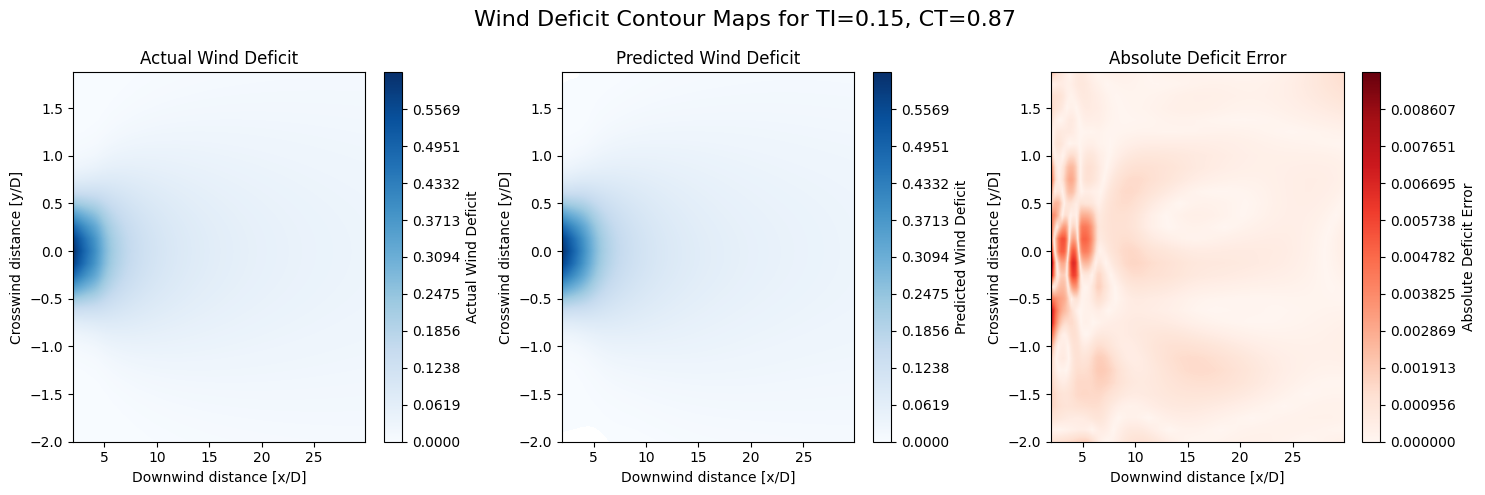

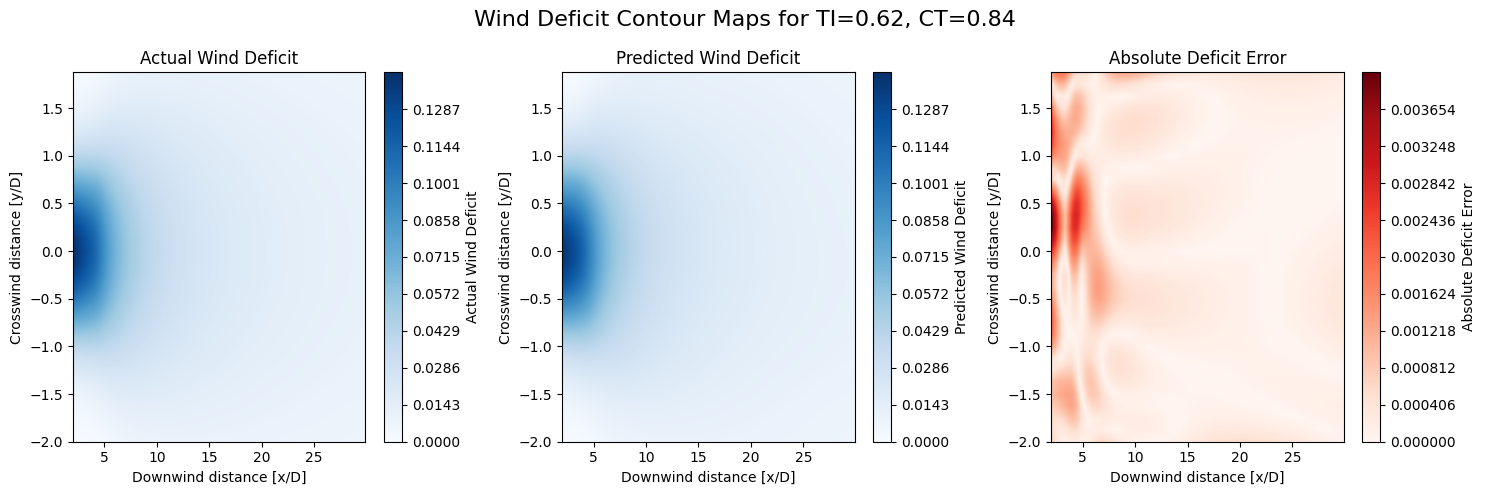

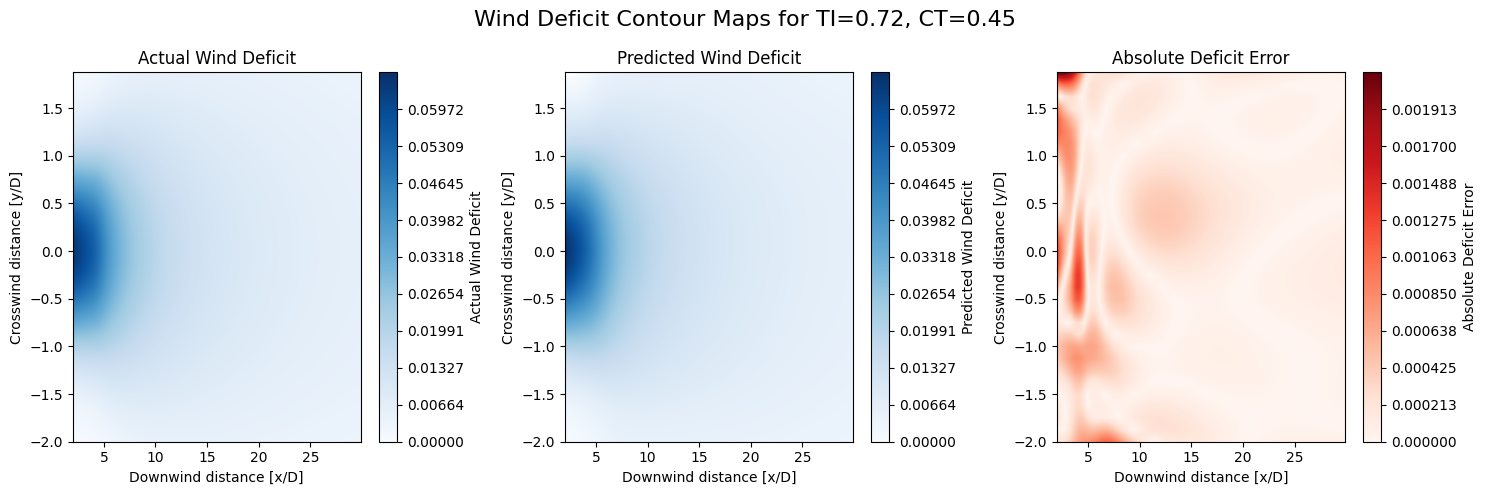

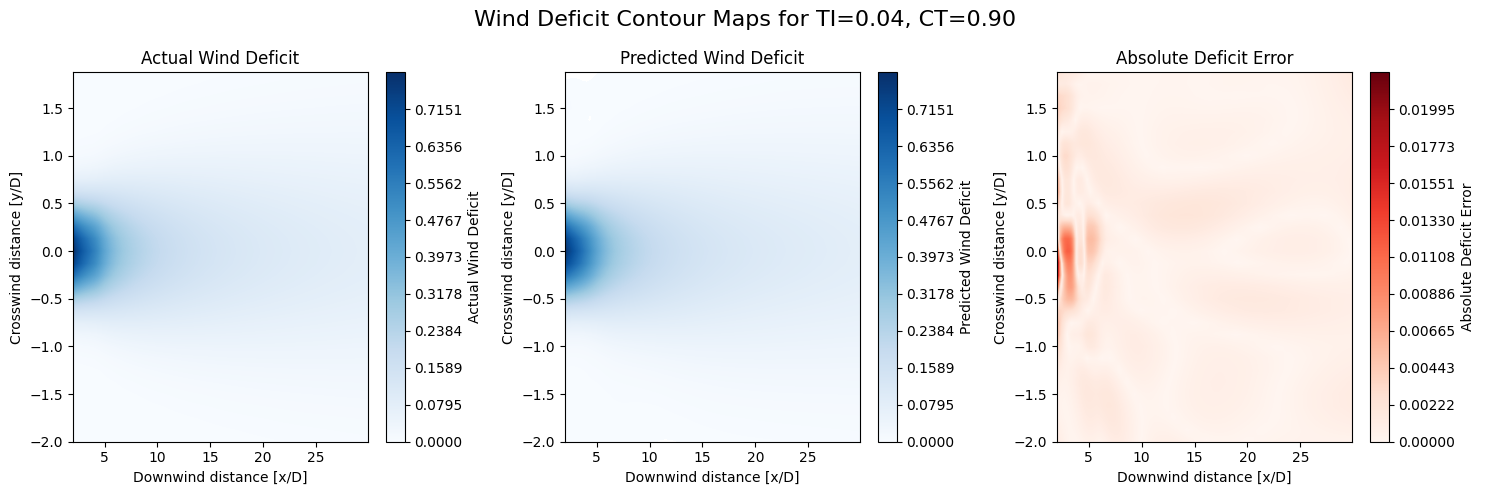

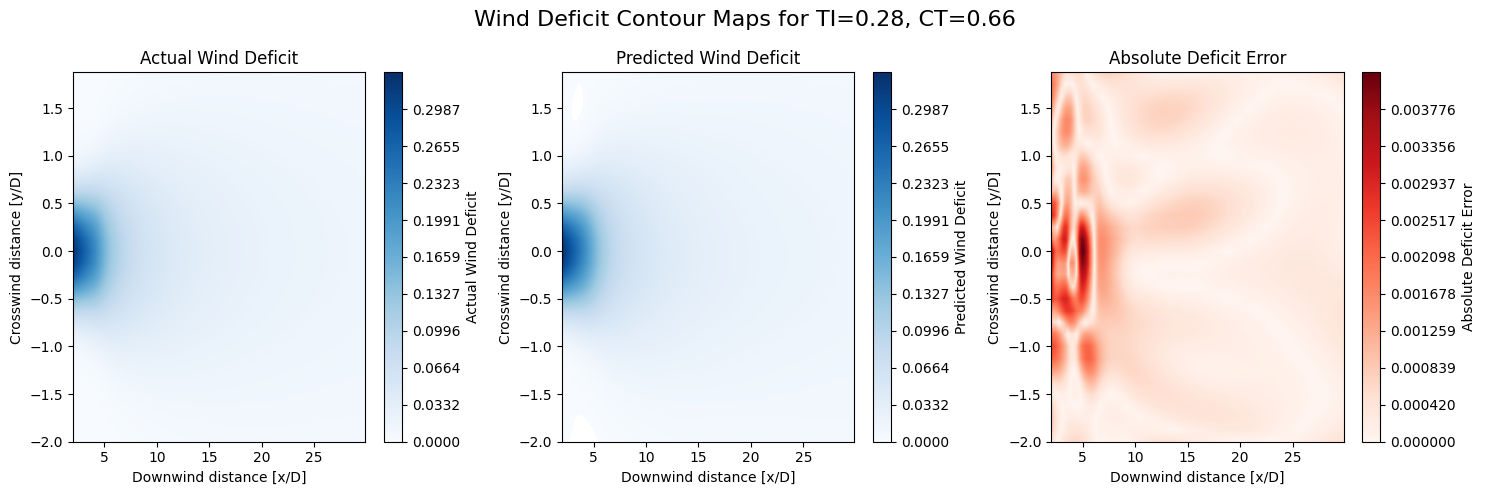

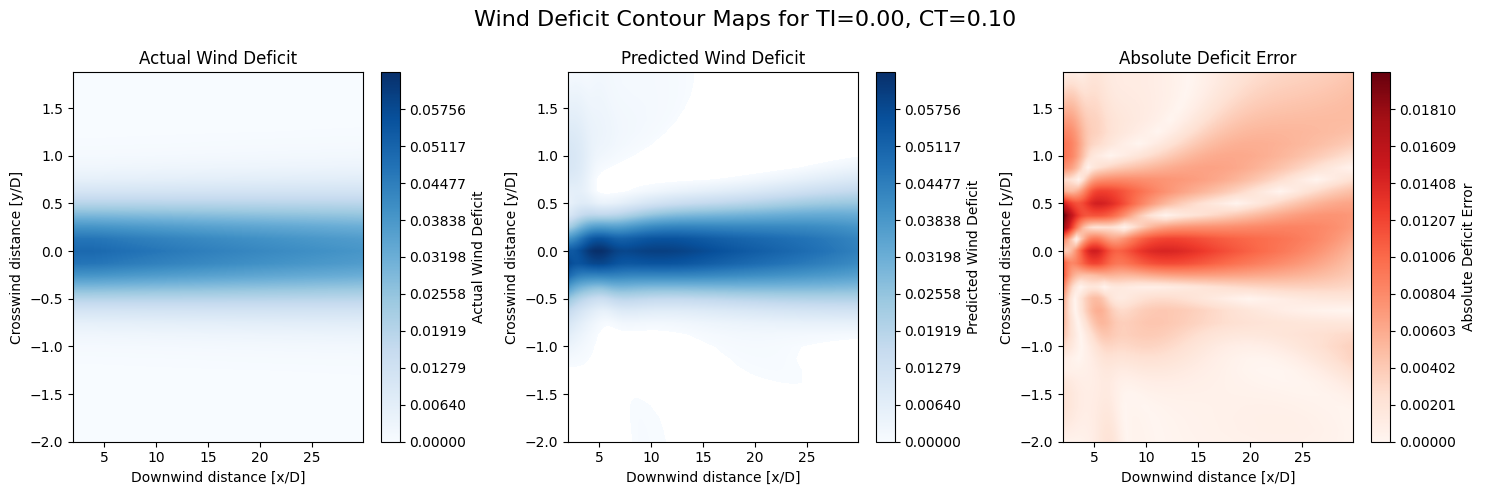

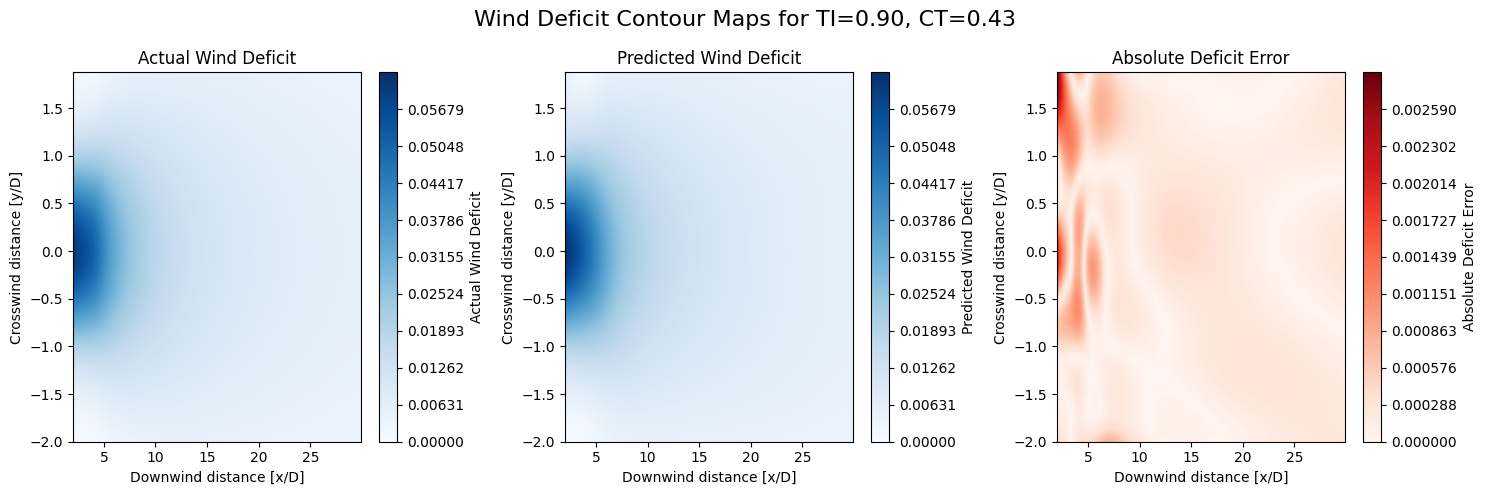

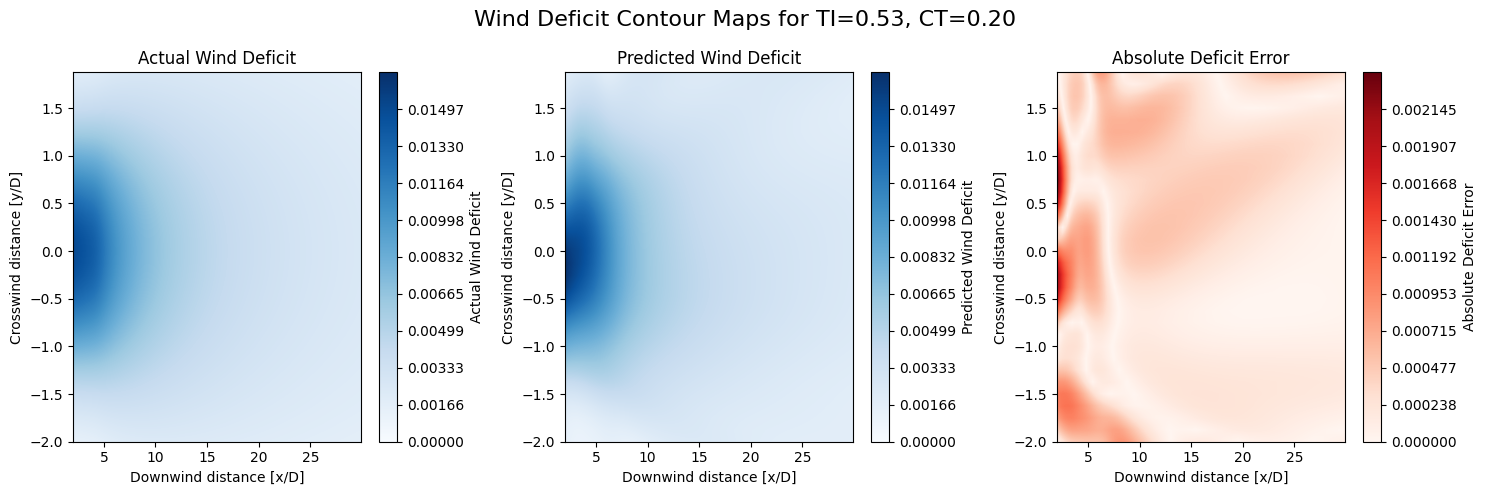

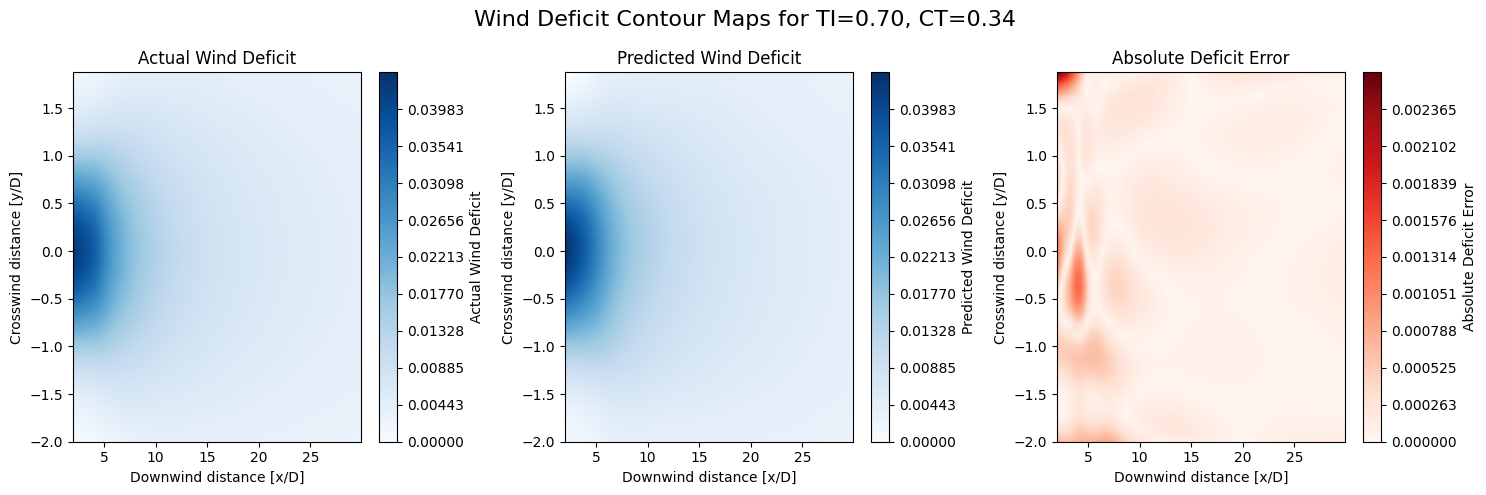

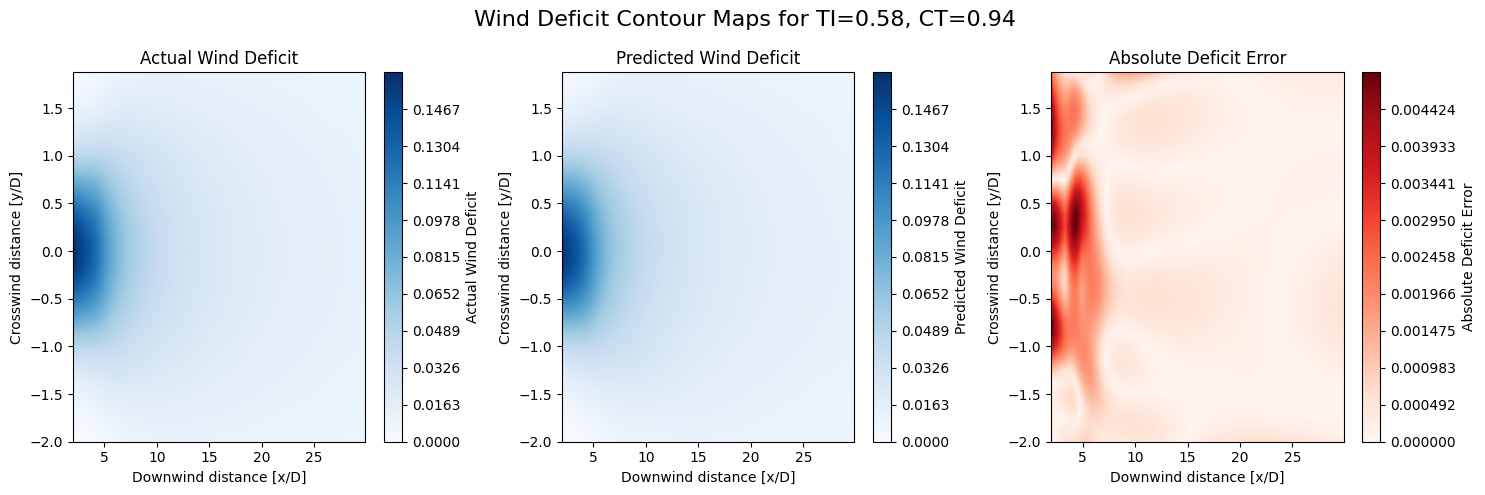

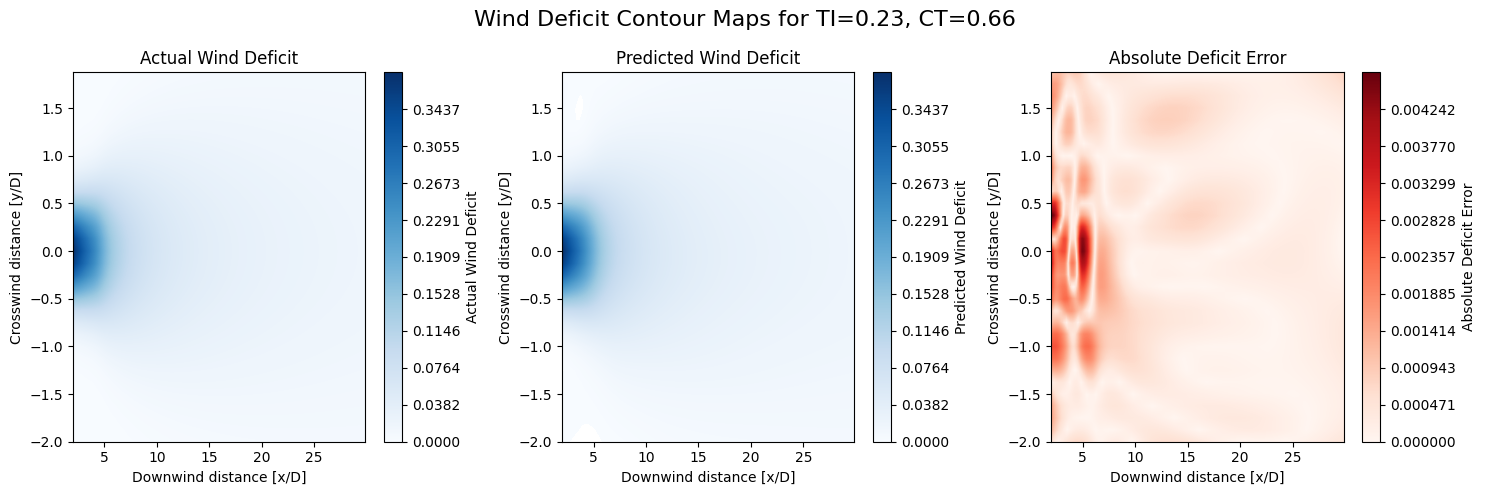

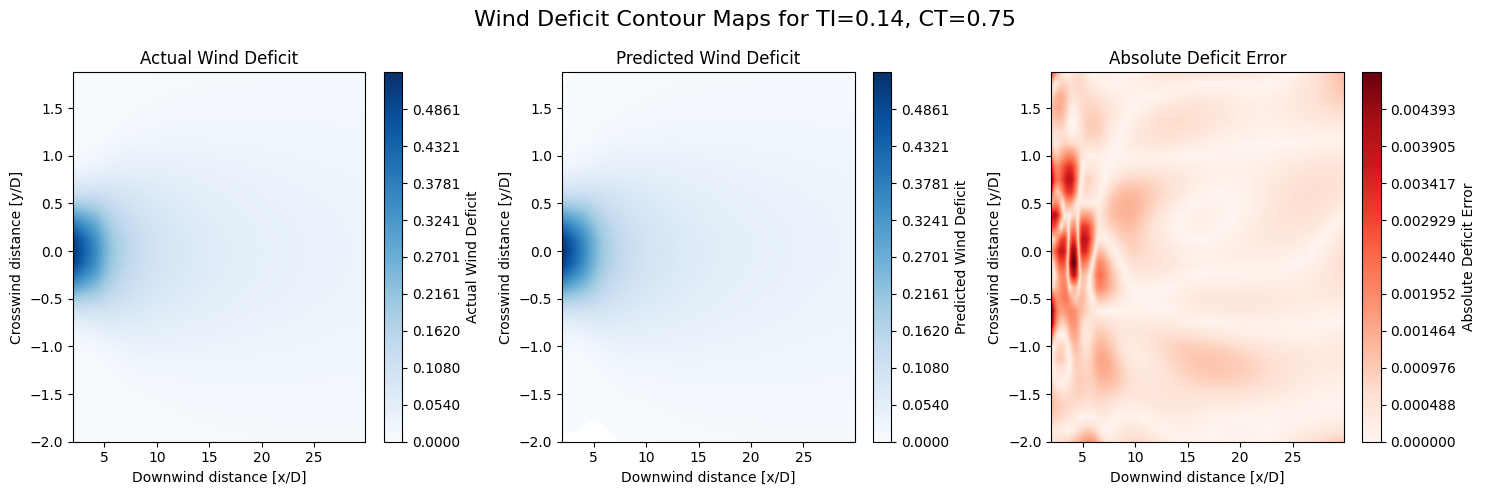

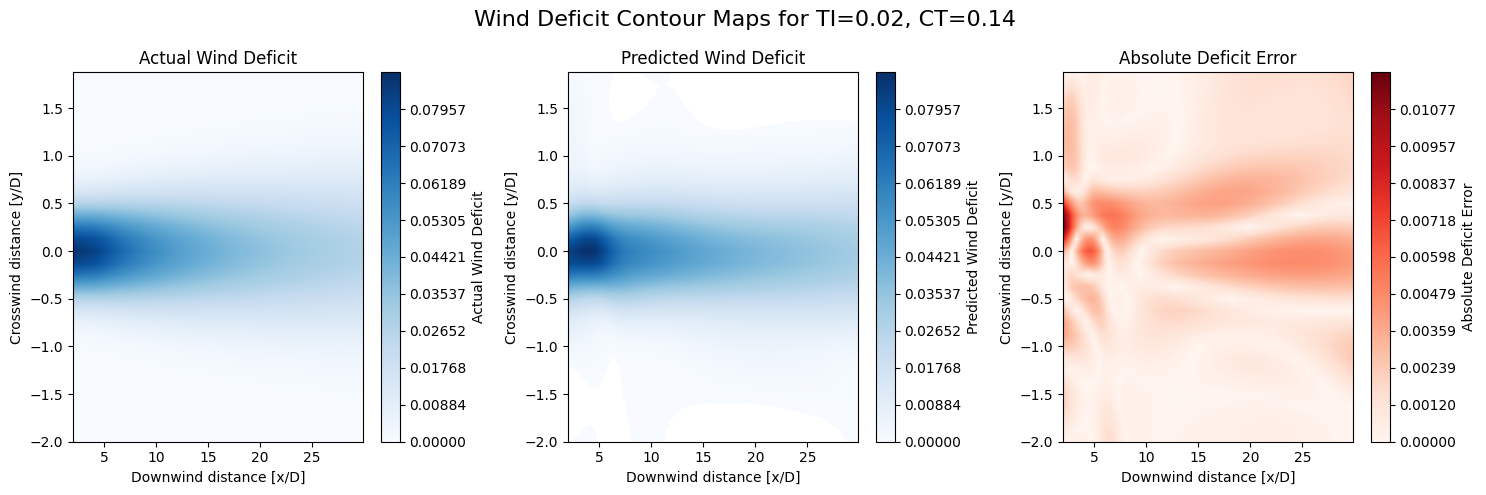

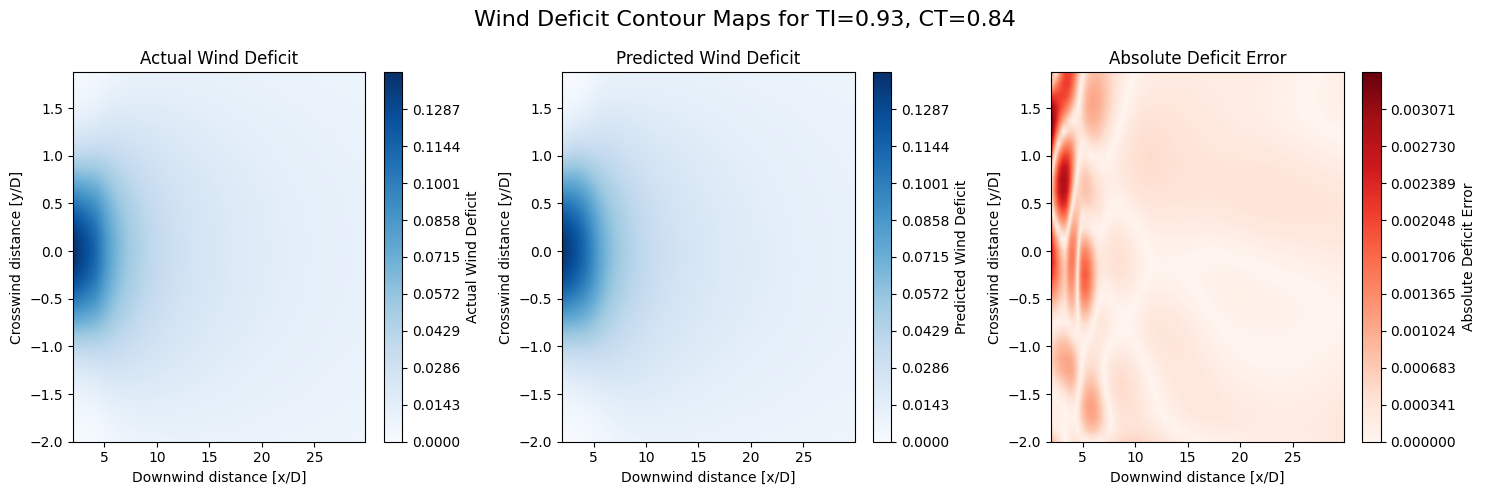

KeyboardInterrupt: 

In [10]:
test_dataset = test_dataloader.dataset
num_cells = test_dataset.num_cells
num_fields = len(test_dataset)//num_cells
field_indices = list(range(num_fields))
random.shuffle(field_indices)

with torch.no_grad():
    for field_idx in field_indices:
        ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_univariate(model, field_idx)
        plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')